<div style="display: flex; text-align:center; background-color: RGB(58,69,203);border: 1px solid RGB(51,165,182);" >
<h1 style="margin: auto;color:RGB(255,255,255); padding: 30px;margin-left: 2em; text-indent: -2em">PROJET 10 - Détectez des faux billets avec R ou Python - Nettoyage et analyses descriptives
    
</h1>
</div>

<div style="border-style: double;border-width: 5px;border-color: RGB(58,69,203);" >
<h3 style="margin: auto; padding: 10px; color: RGB(51,165,182);margin-left: 4.5em; text-indent: -4.5em"><a id="00">SOMMAIRE</a> </h3>
        
  - 1. **[PREPARATION DE DONNEES](#1)**
     - 1. [Qualité des données](#11)
     - 2. [Nettoyage des données - (imputation par regression linéaire)](#12)
  
  - 2. **[ANALYSES DESCRIPTIVES](#2)**
     - 1. [Analyses univariées](#21)
     - 2. [Analyses bivariées](#22)
    
</div>


<div style="border: 1px solid RGB(58,69,203);" >
<h3 style="margin: auto; padding: 10px;margin-left: 4.5em; text-indent: -4.5em">0.0 - Importation des librairies et declaration de fonctions</h3>
</div>

In [1]:
#pip install missingno

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
import seaborn as sns
import pandas as pd
import numpy as np
import missingno as msno
from scipy.stats import zscore

#regression lineaire
from sklearn.metrics import mean_squared_error, r2_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#
import statsmodels
import statsmodels.api as sm
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.set_option('display.max_row',100)

<div style="background-color: RGB(58,69,203);" >
<h2 style="margin: auto;color:RGB(255,255,255) ;padding: 20px;margin-left: 4.5em; text-indent: -4.5em">1 - PREPARATION DE DONNEES</h2>
</div>

<div style="border: 1px solid RGB(58,69,203);" >
<h3 style="margin: auto; padding: 10px;margin-left: 4.5em; text-indent: -4.5em"><a id="11">1 - 1. Qualité des données</a></h3>
</div>

In [3]:
billets = pd.read_csv("./data/source/billets.csv",sep=';',)
billets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [4]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


1. **is_genuine :** Nature du billet (True si le billet est vrai , False sinon).
2. **diagonal :** la diagonale du billet (en mm).
3. **height_left :** la hauteur du billet (mesurée sur le côté gauche, en mm).
4. **height_right :** la hauteur du billet (mesurée sur le côté droit, en mm).
5. **margin_low :** la marge entre le bord inférieur du billet et l'image de celui-ci (en mm).
6. **margin_up :** la marge entre le bord supérieur du billet et l'image de celui-ci (en mm)
7. **length :** la longueur du billet (en mm).


In [5]:
billets.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

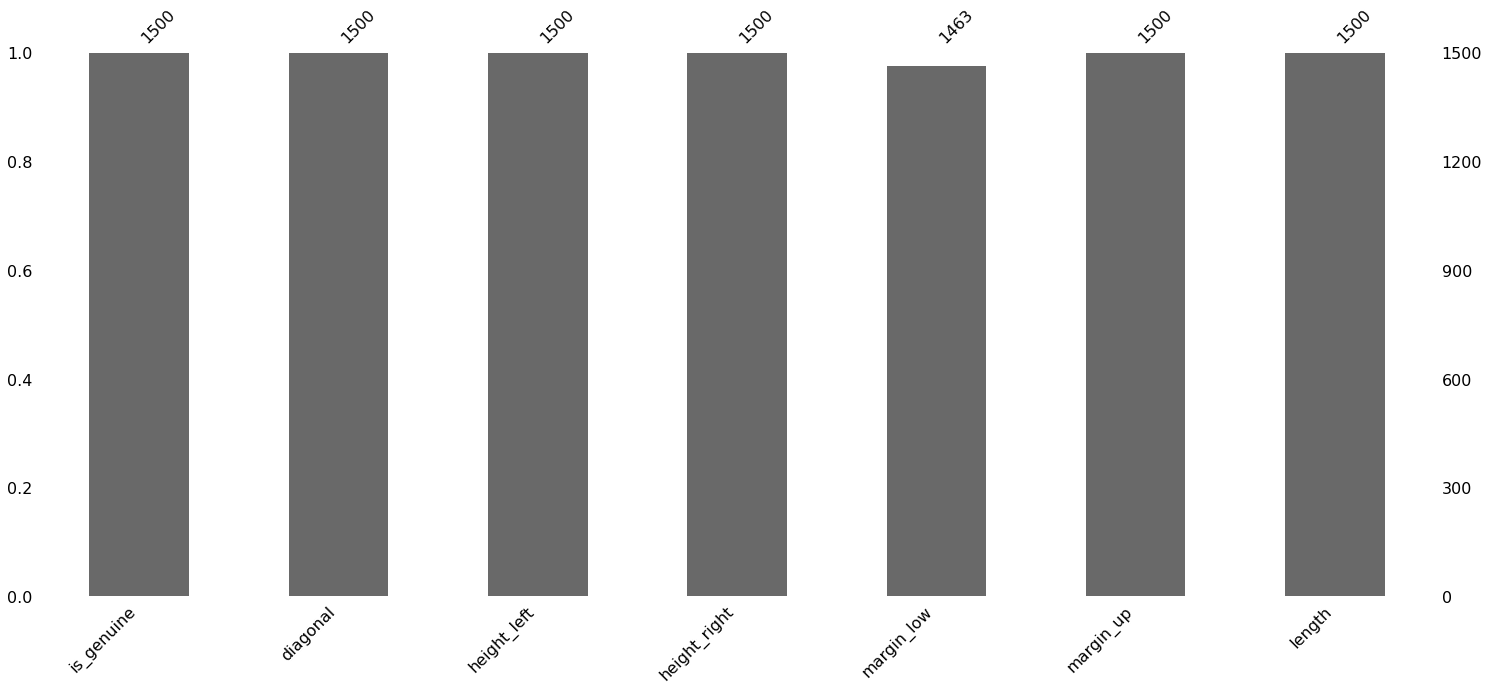

In [6]:
# Visualiser les valeurs manquantes avec missingno
fig = plt.figure(figsize=(10, 6))
msno.bar(billets)
plt.show()


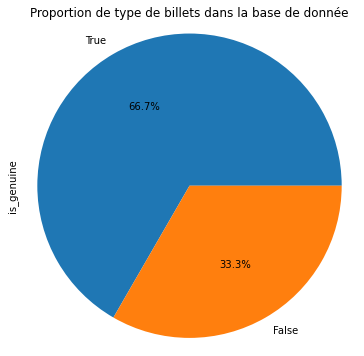

Nombre total de billets 1500


In [7]:

# Générer un pie plot 
fig = plt.figure(figsize=(6, 6))
billets["is_genuine"].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Proportion de type de billets dans la base de donnée")
plt.axis('equal')
plt.show()
fig.savefig('./graphiques/proportion_type_billets.png',dpi=fig.dpi*10)
print("Nombre total de billets",billets.is_genuine.count())

<div style="border: 1px solid RGB(136,202,252);" >
<h3 style="margin: auto; padding: 10px;margin-left: 4.5em; text-indent: -4.5em"><a id="12">1 - 2. Nettoyage des données - (imputation par regression linéaire)</a></h3>
</div>

##### Nous tenterons de mettre en place un model de regression lineaire multiple dans le but de predire les valeurs de la variable "margin_low" (variable à expliquée) en fonction des valeurs des variables "height_left",	"height_right", "margin_up", "length" qui seront nos variables explicatives.

In [8]:
billets_reg = billets[["diagonal", "height_left", "height_right", "margin_up", "length","margin_low"]]
billets_reg.head()

,diagonal,height_left,height_right,margin_up,length,margin_low
0,171.81,104.86,104.95,2.89,112.83,4.52
1,171.46,103.36,103.66,2.99,113.09,3.77
2,172.69,104.48,103.50,2.94,113.16,4.40
3,171.36,103.91,103.94,3.01,113.51,3.62
4,171.73,104.28,103.46,3.48,112.54,4.04


C:\ProgramData\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


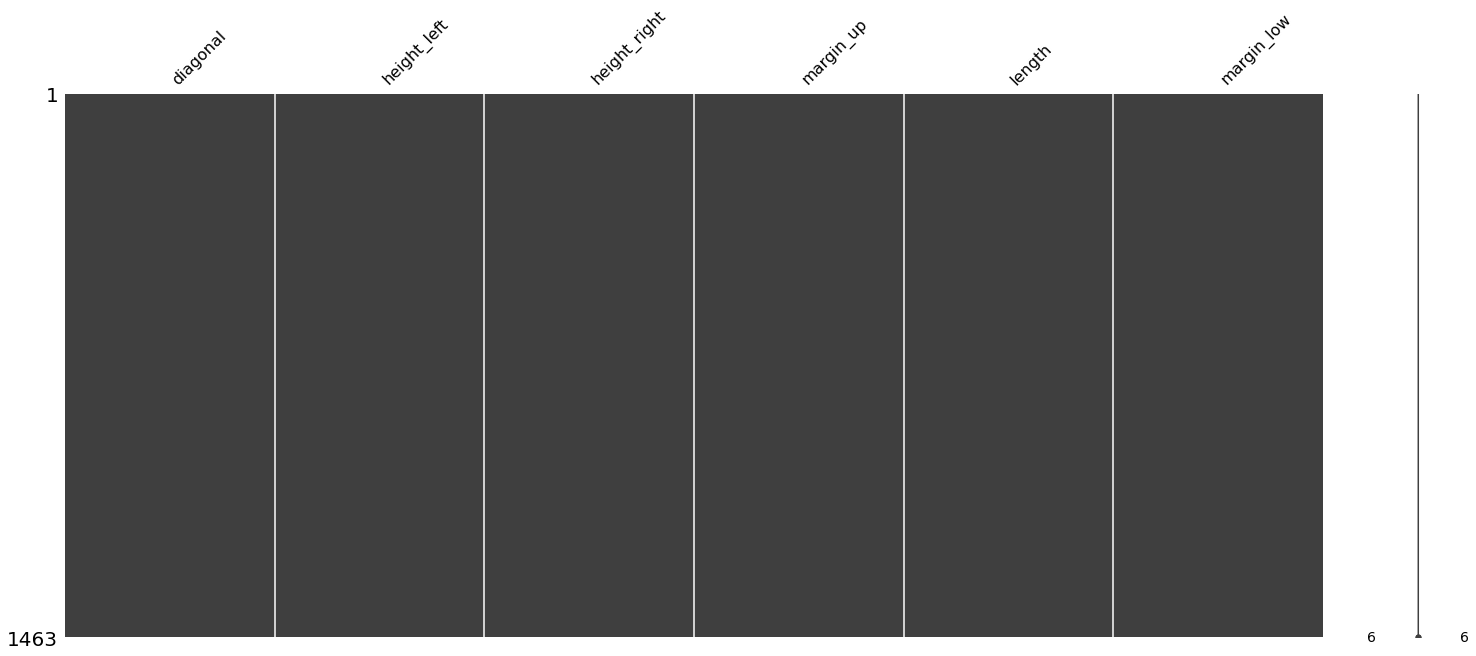

In [9]:
billets_reg.dropna(inplace=True)
msno.matrix(billets_reg)
plt.show()

In [10]:
billets_reg

,diagonal,height_left,height_right,margin_up,length,margin_low
0,171.81,104.86,104.95,2.89,112.83,4.52
1,171.46,103.36,103.66,2.99,113.09,3.77
2,172.69,104.48,103.50,2.94,113.16,4.40
3,171.36,103.91,103.94,3.01,113.51,3.62
4,171.73,104.28,103.46,3.48,112.54,4.04
...,...,...,...,...,...,...
1495,171.75,104.38,104.17,3.09,111.28,4.42
1496,172.19,104.63,104.44,3.37,110.97,5.27
1497,171.80,104.01,104.12,3.36,111.95,5.51
1498,172.06,104.28,104.06,3.46,112.25,5.17


In [11]:
# Résumé statistique des variables
billets_reg.describe()

,diagonal,height_left,height_right,margin_up,length,margin_low
count,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000
mean,171.959193,104.031333,103.921476,3.153083,112.674757,4.485967
std,0.305457,0.299605,0.324181,0.231466,0.873222,0.663813
min,171.040000,103.140000,102.910000,2.270000,109.490000,2.980000
25%,171.750000,103.825000,103.710000,2.990000,112.020000,4.015000
50%,171.960000,104.040000,103.920000,3.140000,112.960000,4.310000
75%,172.170000,104.230000,104.150000,3.315000,113.340000,4.870000
max,173.010000,104.880000,104.950000,3.910000,114.320000,6.900000


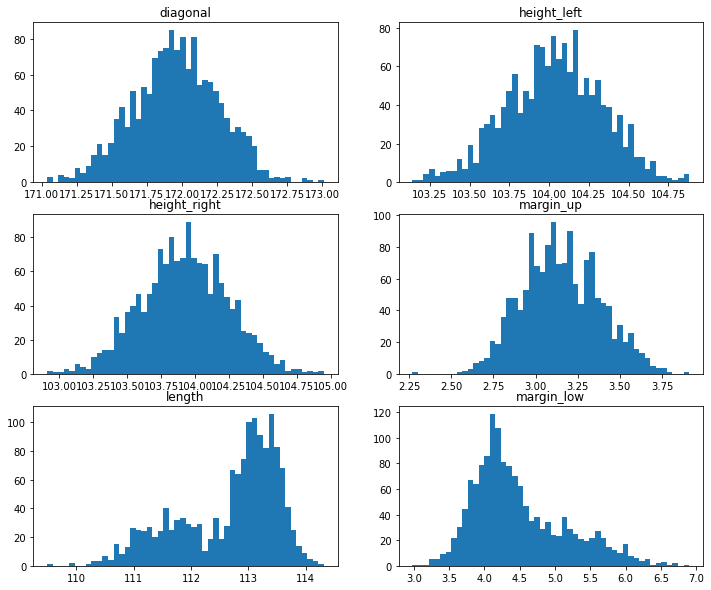

In [12]:
# Visualisation de la distribution des variables
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.ravel()

for i, column in enumerate(billets_reg.columns):
    axs[i].hist(billets_reg[column], bins=50)
    axs[i].set_title(column)

plt.show()
fig.savefig('./graphiques/regression/distribution_variables_reg.png',dpi=fig.dpi*10)
 # Close the figure to free up memory
plt.close(fig)

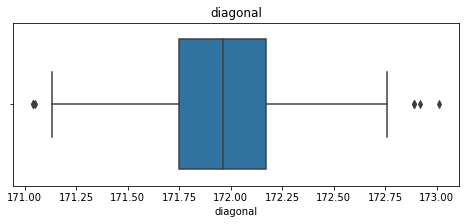

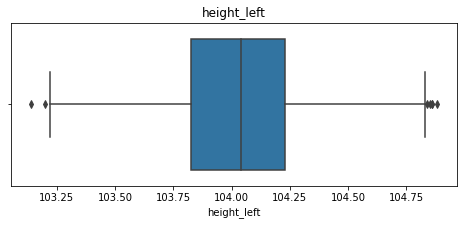

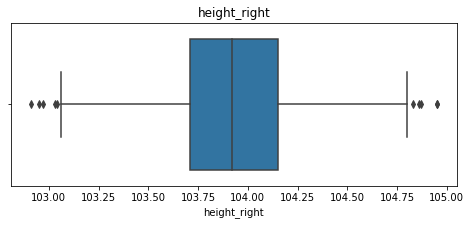

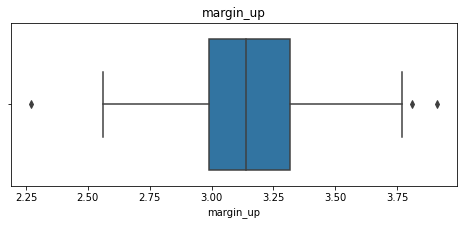

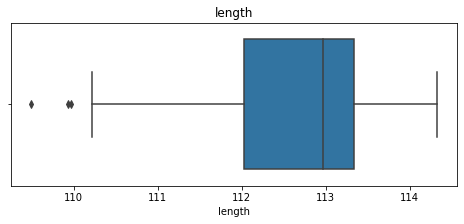

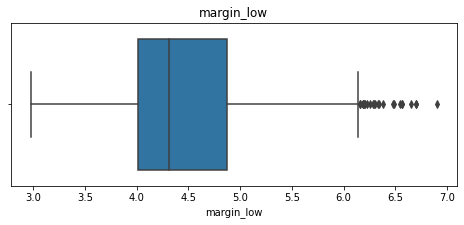

In [13]:

for column in billets_reg.columns:
    fig, ax = plt.subplots(figsize=(8, 3))
    
    # Create a boxplot 
    sns.boxplot(x=billets_reg[column], ax=ax)
    plt.title(column)
    plt.show()
    fig.savefig(f'./graphiques/regression/boxplot_{column}_reg.png', dpi=fig.dpi*10)
    plt.close(fig)


## Corrélation entre les variables

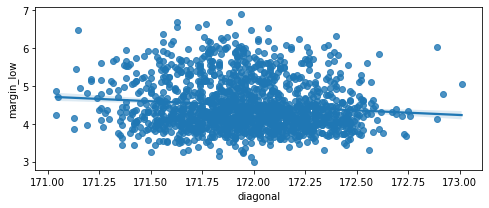

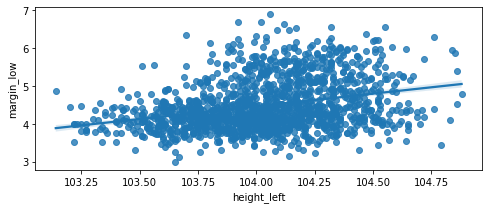

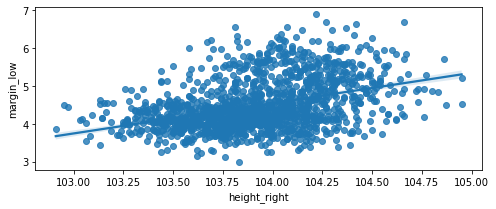

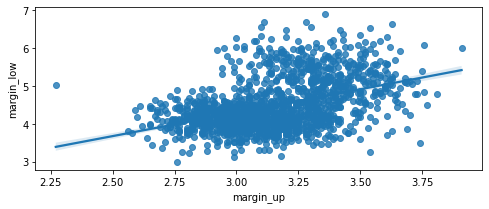

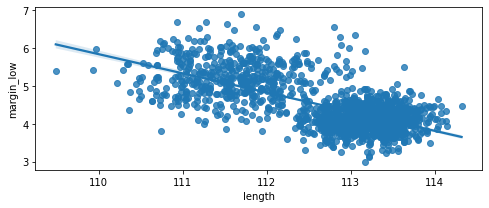

In [14]:

X = billets_reg.drop("margin_low", axis=1)

# Affichage des nuages de points entre la variable à expliquer et toutes les variables explicatives avec seaborn
for col in X.columns:
    fig, ax = plt.subplots(figsize=(8, 3))
    sns.regplot(x=X[col], y=billets_reg["margin_low"])
    plt.show()
    fig.savefig(f'./graphiques/regression/nuage_correlation_{col}_reg.png', dpi=fig.dpi*10)
    plt.close(fig)


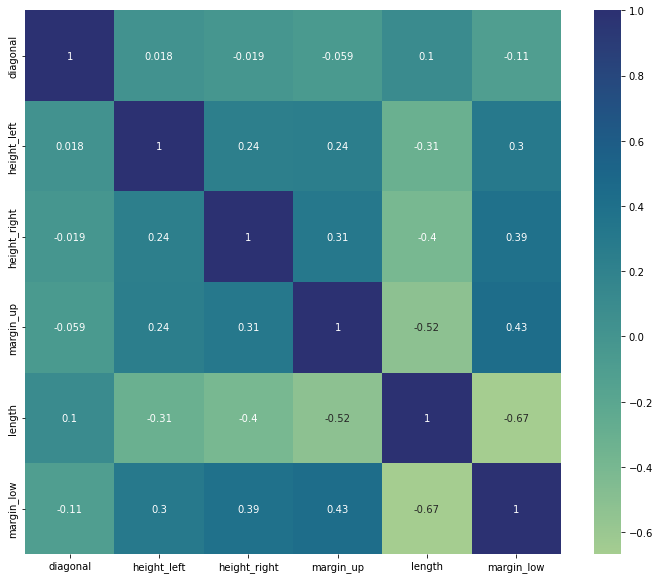

In [15]:
# Calcul de la matrice de corrélation
corr_matrix = billets_reg.corr()


fig = plt.figure(figsize=(12, 10))

# Affichage de la matrice de corrélation sous forme de heatmap avec seaborn
sns.heatmap(corr_matrix, annot=True, cmap="crest")
plt.show()
fig.savefig('./graphiques/regression/matrix_correlation_reg.png', dpi=fig.dpi*10)
plt.close(fig)

In [16]:
billets_reg.columns

Index(['diagonal', 'height_left', 'height_right', 'margin_up', 'length',
       'margin_low'],
      dtype='object')

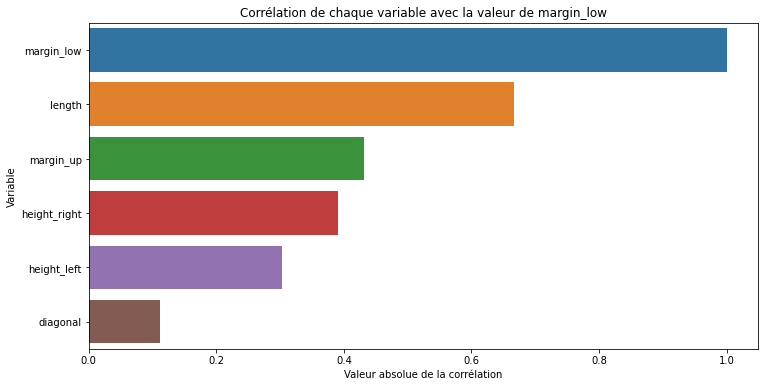

In [17]:

# Calcul de la corrélation entre chaque variable et la variable cible (en valeur absolue)
correlations = abs(billets_reg.corr()["margin_low"]).sort_values(ascending=False)

# Représentation graphique des corrélations
fig = plt.figure(figsize=(12, 6))
sns.barplot(x=correlations.values, y=correlations.index)
plt.xlabel("Valeur absolue de la corrélation")
plt.ylabel("Variable")
plt.title("Corrélation de chaque variable avec la valeur de margin_low")
plt.show()
fig.savefig('./graphiques/regression/bar_correlation_with_margin_low_reg.png', dpi=fig.dpi*10)
plt.close(fig)

# Division en Train et en Test

In [18]:

# Diviser les données en ensembles d'apprentissage et de test

train, test = train_test_split(billets_reg, test_size=0.2, random_state=42)



## Sélection des features sur la base train

In [19]:
# Résumé statistique des variables
train.describe()

,diagonal,height_left,height_right,margin_up,length,margin_low
count,1170.000000,1170.000000,1170.000000,1170.000000,1170.000000,1170.000000
mean,171.962906,104.036077,103.922222,3.154085,112.674205,4.484786
std,0.299311,0.300680,0.327694,0.234868,0.875115,0.667411
min,171.050000,103.140000,102.910000,2.270000,109.970000,2.980000
25%,171.752500,103.820000,103.710000,2.990000,112.035000,4.020000
50%,171.960000,104.040000,103.920000,3.140000,112.950000,4.310000
75%,172.170000,104.240000,104.150000,3.310000,113.337500,4.860000
max,172.890000,104.880000,104.950000,3.910000,114.320000,6.900000


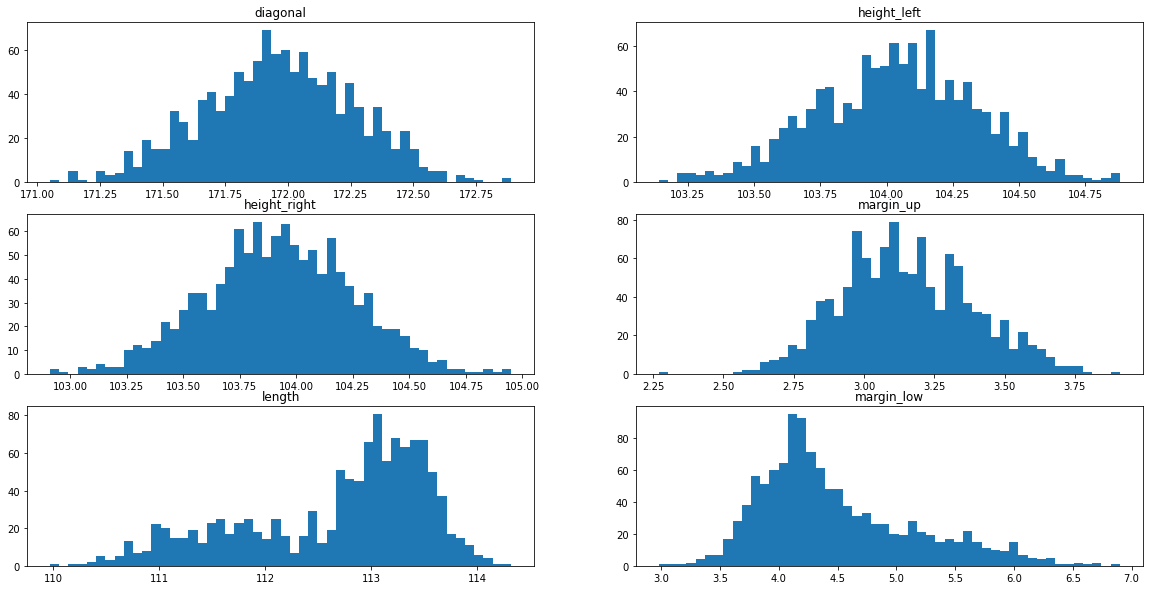

In [20]:
# Visualisation de la distribution des variables
fig, axs = plt.subplots(3, 2, figsize=(20, 10))
axs = axs.ravel()

for i, column in enumerate(train.columns):
    axs[i].hist(train[column], bins=50)
    axs[i].set_title(column)

plt.show()
fig.savefig(f'./graphiques/regression/distribution_variables_train.png', dpi=fig.dpi*10)
plt.close(fig)

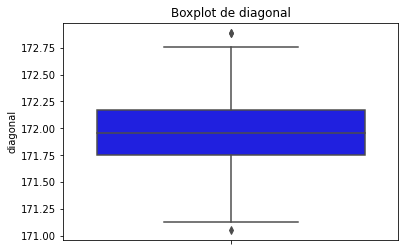

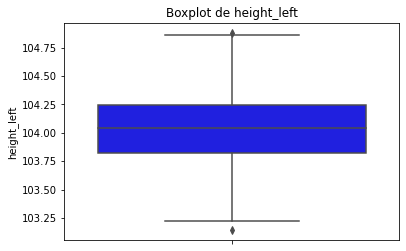

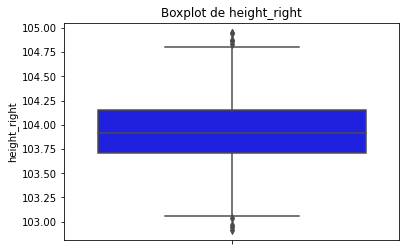

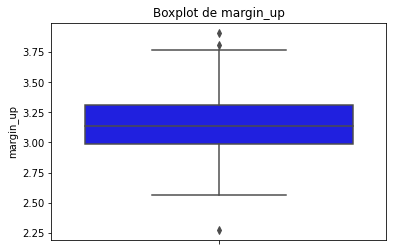

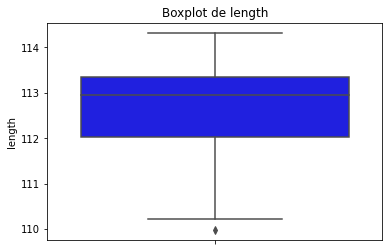

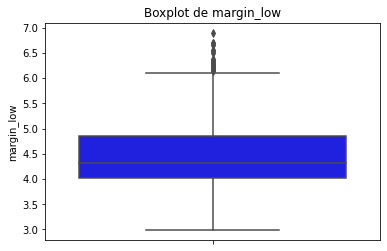

In [21]:

# Affichage des boxplots pour chaque variable numérique
num_cols = list(train.select_dtypes(include=["float64", "int64"]).columns)

for col in num_cols:
    fig = plt.figure(figsize=(6, 4))
    sns.boxplot(data=train, y=col, color="blue")
    plt.title(f"Boxplot de {col}")
    plt.ylabel(col)
    plt.show()
    fig.savefig(f'./graphiques/regression/boxplot_{column}_train.png', dpi=fig.dpi*10)
    plt.close(fig)

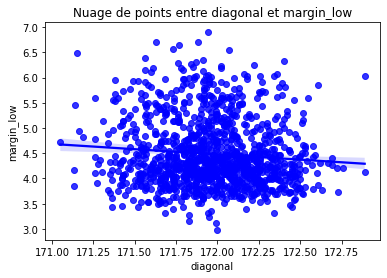

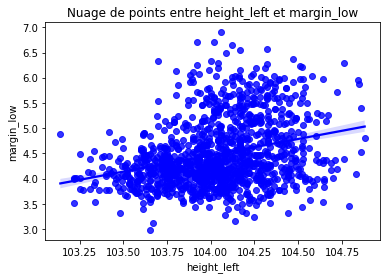

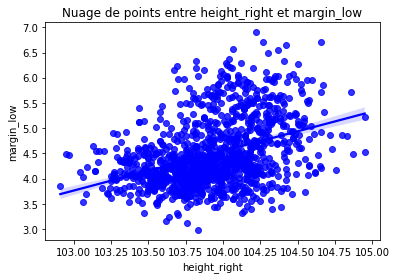

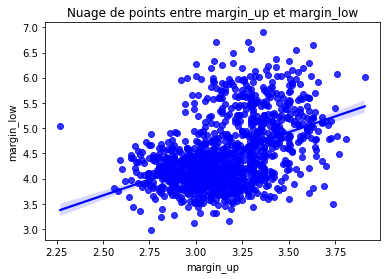

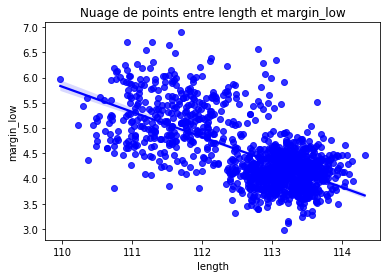

In [22]:
# Affichage des nuages de points entre la variable d'intérêt et chacunes des autres variables
target_col = "margin_low"
num_cols = list(train.select_dtypes(include=["float64", "int64"]).columns)
num_cols.remove(target_col)

for col in num_cols:
    fig = plt.figure(figsize=(6, 4))
    sns.regplot(data=train, x=col, y=target_col, color="blue")
    plt.title(f"Nuage de points entre {col} et {target_col}")
    plt.xlabel(col)
    plt.ylabel(target_col)
    plt.show()
    fig.savefig(f'./graphiques/regression/nuage_correlation_marginLow_{column}_train.png', dpi=fig.dpi*10)
    plt.close(fig)

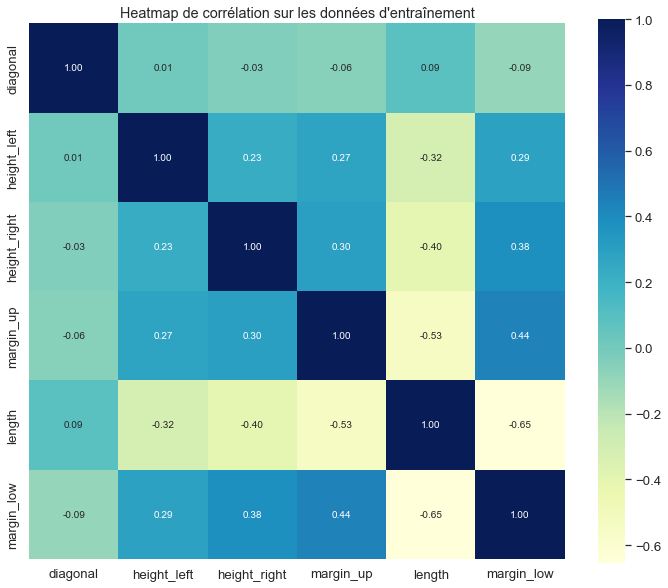

In [23]:
# Calcul de la matrice de corrélation sur les données d'entraînement
corr_matrix_train = train.corr()


sns.set(font_scale=1.2)
fig = plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_train, cmap="YlGnBu", annot=True, annot_kws={"size": 10}, square=True, fmt=".2f")

plt.title("Heatmap de corrélation sur les données d'entraînement")
plt.show()
fig.savefig('./graphiques/regression/matrix_correlation_reg_train.png', dpi=fig.dpi*10)
plt.close(fig)

In [24]:

# Séparation des variables prédictives et de la variable cible

X_train = train.drop("margin_low", axis=1)
y_train = train["margin_low"]

X_test = test.drop("margin_low", axis=1)
y_test = test["margin_low"]

# Fit du modèle linéaire
lr_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     198.7
Date:                Tue, 27 Aug 2024   Prob (F-statistic):          3.54e-153
Time:                        01:50:02   Log-Likelihood:                -825.58
No. Observations:                1170   AIC:                             1663.
Df Residuals:                    1164   BIC:                             1694.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           20.3960     11.266      1.810   

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [25]:
# Obtention des prédictions et des métriques d'évaluation
y_train_pred = lr_model.predict(sm.add_constant(X_train))
y_test_pred = lr_model.predict(sm.add_constant(X_test))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [26]:
# Construction du tableau de résultats

df_metrics = pd.DataFrame({
    'Métrique': ['R2', 'MSE', 'RMSE'],
    'Train': [r2_train, mse_train, rmse_train],
    'Test': [r2_test, mse_test, rmse_test]
})

df_metrics


,Métrique,Train,Test
0,R2,0.460481,0.545796
1,MSE,0.240117,0.191450
2,RMSE,0.490017,0.437549


In [27]:
std_margin_low = np.std(billets_reg["margin_low"])
std_margin_low

0.6635857184711103

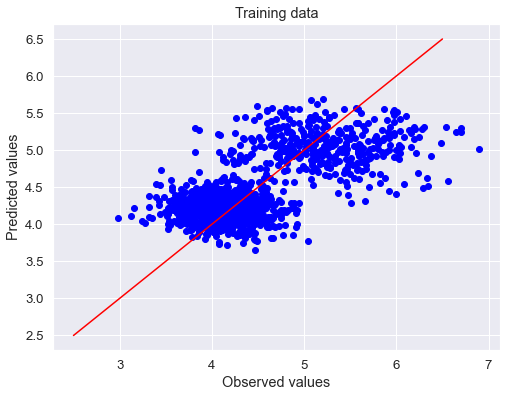

In [28]:
# Tracer les valeurs observées en fonction des valeurs prédites sur les données d'entraînement
fig = plt.figure(figsize=(8, 6))
#sns.regplot(y_train, y_train_pred, color='blue',line_kws=dict(color="r"))
plt.scatter(y_train, y_train_pred, color='blue')
plt.xlabel('Observed values')
plt.ylabel('Predicted values')
plt.title('Training data')
plt.plot(np.arange(2.5, 8, 2), np.arange(2.5, 8, 2), color='red')
plt.show()
fig.savefig('./graphiques/regression/nuage_observed_predicted_train.png', dpi=fig.dpi*10)
plt.close(fig)


In [29]:
billets.columns

Index(['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length'],
      dtype='object')

In [30]:
a_prevoir = billets[['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length']]
X_billets_isnull = a_prevoir.loc[a_prevoir['margin_low'].isnull()]
X_billets_isnull = X_billets_isnull[['diagonal', 'height_left', 'height_right',
       'margin_up', 'length']]
X_billets_isnull

,diagonal,height_left,height_right,margin_up,length
72,171.94,103.89,103.45,3.25,112.79
99,171.93,104.07,104.18,3.14,113.08
151,172.07,103.80,104.38,3.02,112.93
197,171.45,103.66,103.80,3.62,113.27
241,171.83,104.14,104.06,3.02,112.36
251,171.80,103.26,102.82,2.95,113.22
284,171.92,103.83,103.76,3.23,113.29
334,171.85,103.70,103.96,3.00,113.36
410,172.56,103.72,103.51,3.12,112.95
413,172.30,103.66,103.50,3.16,112.95


In [31]:
margin_low_prev = lr_model.predict(sm.add_constant(X_billets_isnull))
margin_low_prev

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


72      4.323133
99      4.393907
151     4.416845
197     4.337374
241     4.634614
251     3.815222
284     4.190862
334     4.133982
410     4.156725
413     4.179140
445     4.168849
481     3.775417
505     4.063689
611     4.307835
654     4.152929
675     4.073864
710     4.437730
739     4.474235
742     4.349957
780     4.097550
798     3.629682
844     4.360967
845     4.088648
871     4.234759
895     3.903429
919     3.742329
945     4.242111
946     4.711299
981     4.131895
1076    5.026958
1121    4.774697
1176    5.037325
1303    5.013806
1315    4.781467
1347    5.698913
1435    5.194886
1438    5.121098
dtype: float64

## Vérification des hypothèses du modele

### Vérification de l'homoscedasticité

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


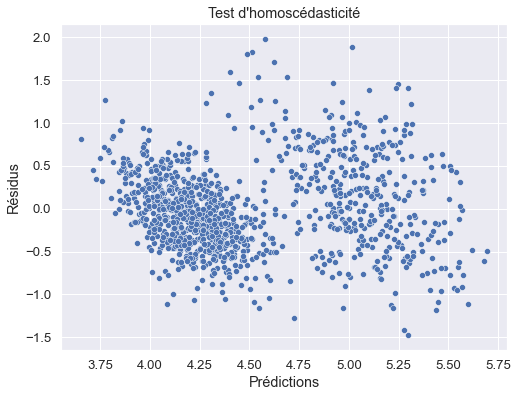

In [32]:
# Test d'homoscédasticité
y_train_pred = lr_model.predict(sm.add_constant(X_train))
residuals = y_train - y_train_pred
fig = plt.figure(figsize=(8, 6))
sns.scatterplot(y_train_pred, residuals)
plt.title('Test d\'homoscédasticité')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.show()
fig.savefig('./graphiques/regression/test_homoscedasticite.png', dpi=fig.dpi*10)
plt.close(fig)

On peut constater que la variance des résidus a tendance a croitre avec l'augmentation des prédictions .

In [33]:
# Test de Breusch-Pagan
bp_test = sm.stats.diagnostic.het_breuschpagan(lr_model.resid, lr_model.model.exog)
print("Test de Breusch-Pagan : statistique = %f, p-value = %f" % (bp_test[0], bp_test[1]))

Test de Breusch-Pagan : statistique = 68.736561, p-value = 0.000000


La p-valeur ici est inférieure à $5$%, on rejette l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité n'est pas verifiée).

### Vérification de la multicolinéarité

In [34]:
# Test de multicollinéarité
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
print(vif)

      VIF Factor      features
0  168489.805290      diagonal
1  112050.451067   height_left
2   97264.947723  height_right
3     260.285642     margin_up
4   22753.618009        length


### Vérification de la normalité

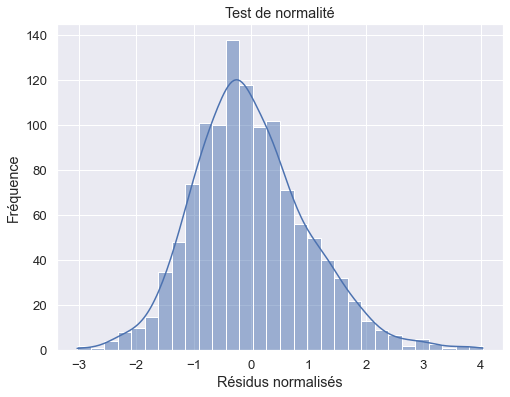

In [35]:
# Test de normalité
resid_norm = lr_model.get_influence().resid_studentized_internal
fig = plt.figure(figsize=(8, 6))
sns.histplot(resid_norm, kde=True)
plt.title('Test de normalité')
plt.xlabel('Résidus normalisés')
plt.ylabel('Fréquence')
plt.show()
fig.savefig('./graphiques/regression/test_normalite.png', dpi=fig.dpi*10)
plt.close(fig)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


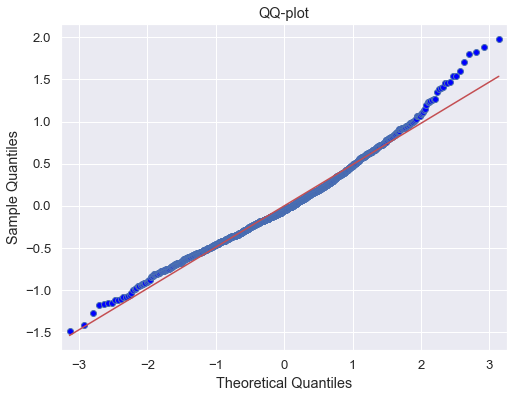

In [36]:
# QQ-plot
fig, ax = plt.subplots(figsize=(8, 6))
sm.qqplot(residuals, line='s', ax=ax)
ax.set_title('QQ-plot')
plt.show()
fig.savefig('./graphiques/regression/QQ-plot.png', dpi=fig.dpi*10)
plt.close(fig)

In [37]:
import scipy.stats as stats

# Test de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)

# Test d'Anderson-Darling
anderson_test = stats.anderson(residuals, dist='norm')

# Test de Kolmogorov-Smirnov
ks_test = stats.kstest(residuals, 'norm')

# Mettre les résultats dans un dataframe
df_normality = pd.DataFrame({
    'Test de normalité': ['Shapiro-Wilk', 'Anderson-Darling', 'Kolmogorov-Smirnov'],
    'Statistique': [shapiro_test.statistic, anderson_test.statistic, ks_test.statistic],
    'p-value': [shapiro_test.pvalue, 'N/A', ks_test.pvalue]
})

# Afficher le tableau
print(df_normality)

    Test de normalité  Statistique p-value
0        Shapiro-Wilk     0.983914     0.0
1    Anderson-Darling     4.643782     N/A
2  Kolmogorov-Smirnov     0.192652     0.0


Ici, l'hypothèse de normalité est remise en cause (pvalue=0.00 < 0.05 ).



### Vérification de l'autocorrélation

In [38]:
from statsmodels.stats.stattools import durbin_watson
# Test d'autocorrélation
dw_test = durbin_watson(lr_model.resid)
print("Test de Durbin-Watson : statistique = %f" % dw_test)

Test de Durbin-Watson : statistique = 1.980619


Interprétation des Résultats
0 ≤ d < 2 : Autocorrélation positive. Plus 
𝑑
d est proche de 0, plus l'autocorrélation positive est forte.
d ≈ 2 : Absence d'autocorrélation.
2 < d ≤ 4 : Autocorrélation négative. Plus 
𝑑
d est proche de 4, plus l'autocorrélation négative est forte.

#### On a donc pas d'autocorelation des residus .

### Moyenne des termes d'erreur

In [39]:
residuals.mean()

9.563138505207959e-14

#### Interprétation de l'erreur moyenne
ME ≈ 0 : Si la moyenne des erreurs est proche de zéro, cela indique qu'il n'y a pas de biais systématique dans les prédictions du modèle. Les erreurs positives et négatives s'annulent en moyenne.</br>
ME > 0 : Une ME positive signifie que le modèle a tendance à sous-estimer les valeurs observées. Les prédictions sont généralement plus basses que les valeurs réelles.</br>
ME < 0 : Une ME négative signifie que le modèle a tendance à surestimer les valeurs observées. Les prédictions sont généralement plus élevées que les valeurs réelles.</br>

#### La moyenne des termes d' erreurs est environ égale à 0 ; Les erreurs  positives et négatives s\'annulent en moyenne.

### Imputation

In [40]:
billets.loc[billets['margin_low'].isnull(),"margin_low"]=margin_low_prev

In [41]:
billets.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

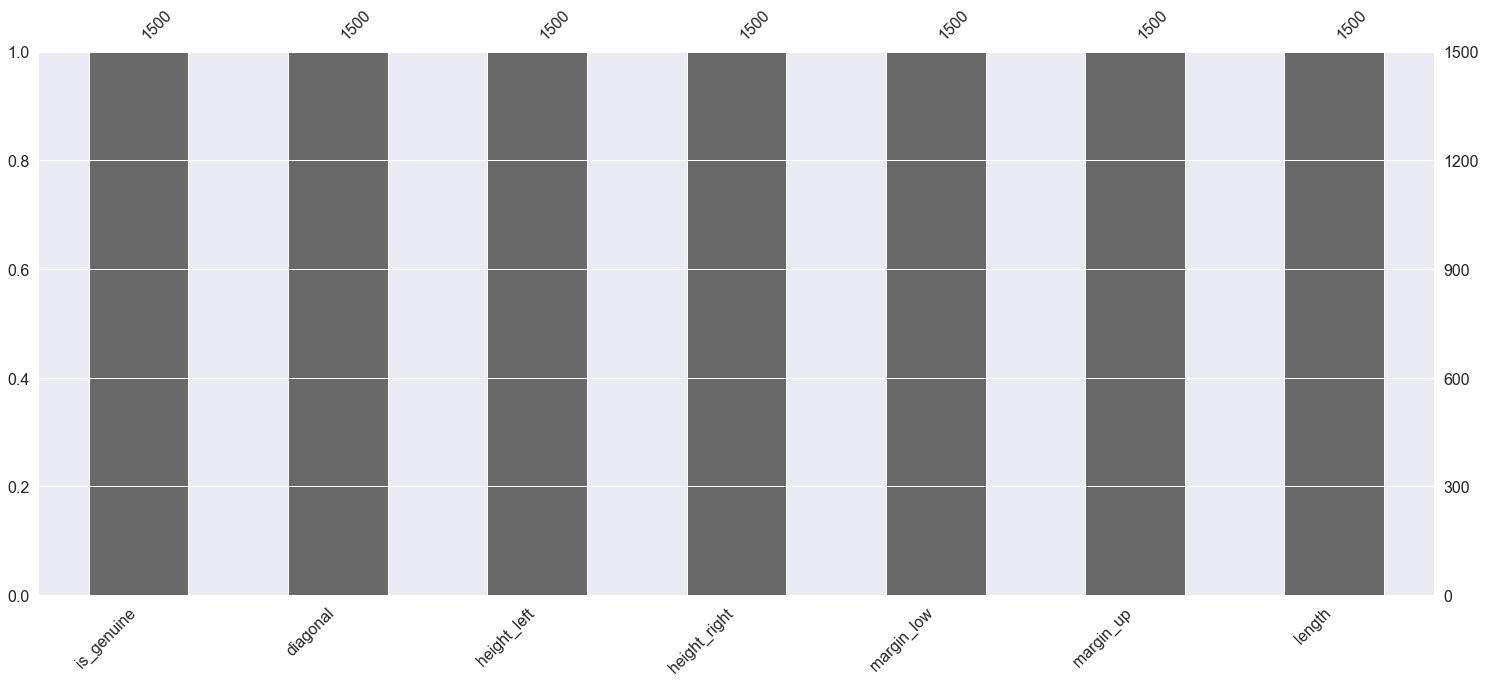

In [42]:
# Visualiser les valeurs manquantes avec missingno
msno.bar(billets)
plt.show()
#fig.savefig('./graphiques/regression/valeurs_manquantes_apres_imputation.png', dpi=fig.dpi*10)


In [43]:
billets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


-----------------------------------------------------------------------------------

In [44]:
billets.columns

Index(['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length'],
      dtype='object')

In [45]:
billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.483432,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659489,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.020000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [46]:
Labelencoder = LabelEncoder()


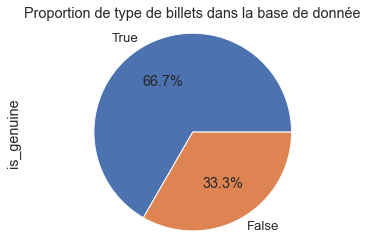

Nombre total de billets 1500


In [47]:
# repartition des billets dans la base de données

# Générer un pie plot 
fig = plt.figure(figsize=(6, 4))
billets["is_genuine"].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Proportion de type de billets dans la base de donnée")
plt.axis('equal')
plt.show()
print("Nombre total de billets",billets.is_genuine.count())
fig.savefig('./graphiques/proportion_type_billets2.png', dpi=fig.dpi*10)
plt.close(fig)

In [48]:
billets_drop = billets.copy()
billets_drop["is_genuine"] = Labelencoder.fit_transform(billets["is_genuine"])
billets_drop

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,0,171.75,104.38,104.17,4.42,3.09,111.28
1496,0,172.19,104.63,104.44,5.27,3.37,110.97
1497,0,171.80,104.01,104.12,5.51,3.36,111.95
1498,0,172.06,104.28,104.06,5.17,3.46,112.25


In [49]:
billets["is_genuine_encode"] = Labelencoder.fit_transform(billets["is_genuine"])

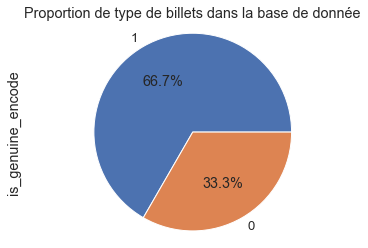

Nombre total de billets 1000


In [50]:
# repartition des billets dans la base de données

# Générer un pie plot 
fig = plt.figure(figsize=(6,4))
billets["is_genuine_encode"].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Proportion de type de billets dans la base de donnée")
plt.axis('equal')
plt.show()
print("Nombre total de billets",billets.is_genuine.sum())
fig.savefig('./graphiques/proportion_type_billets_encode.png', dpi=fig.dpi*10)
plt.close(fig)

In [51]:
billets.to_csv("./data/cleaned/billets_clean.csv",index=False)

<div style="background-color: RGB(58,69,203);" >
<h2 style="margin: auto;color:RGB(255,255,255) ;padding: 20px;margin-left: 4.5em; text-indent: -4.5em">2 - ANALYSES DESCRIPTIVES</h2>
</div>

<div style="border: 1px solid RGB(136,202,252);" >
<h3 style="margin: auto; padding: 10px;margin-left: 4.5em; text-indent: -4.5em"><a id="21">2 - 1. Analyses univariées</a></h3>
</div>

In [52]:
billets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine_encode
0,True,171.81,104.86,104.95,4.52,2.89,112.83,1
1,True,171.46,103.36,103.66,3.77,2.99,113.09,1
2,True,172.69,104.48,103.50,4.40,2.94,113.16,1
3,True,171.36,103.91,103.94,3.62,3.01,113.51,1
4,True,171.73,104.28,103.46,4.04,3.48,112.54,1
...,...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28,0
1496,False,172.19,104.63,104.44,5.27,3.37,110.97,0
1497,False,171.80,104.01,104.12,5.51,3.36,111.95,0
1498,False,172.06,104.28,104.06,5.17,3.46,112.25,0


In [53]:
# Créer une nouvelle version de la base de données sans la variable "response"
billets_numeric = billets.drop(columns=['is_genuine','is_genuine_encode'])
billets_numeric.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54


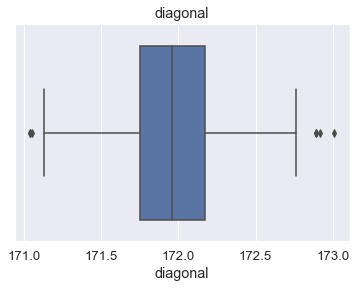

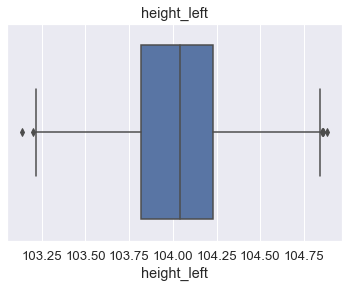

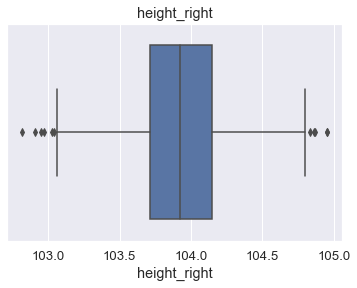

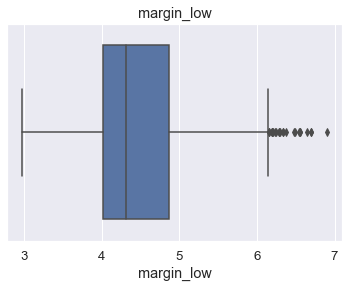

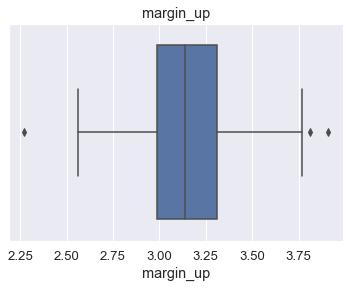

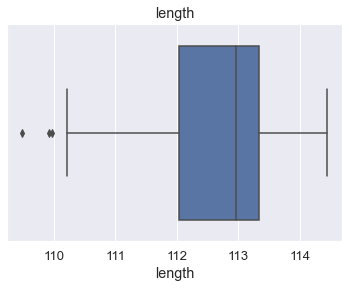

In [54]:

# Sélectionner les variables numériques
num_vars = billets_numeric.columns

# Générer un box plot pour chaque variable numérique
for var in num_vars:
    fig = plt.figure(figsize=(6,4))
    sns.boxplot(x=billets[var])
    plt.title(var)
    plt.show()
    fig.savefig(f'./graphiques/univarie/boxplot_{var}_univarie.png', dpi=fig.dpi*10)
    plt.close(fig)

<div style="border: 1px solid RGB(136,202,252);" >
<h3 style="margin: auto; padding: 10px;margin-left: 4.5em; text-indent: -4.5em"><a id="22">2 - 2. Analyses bivariées</a></h3>
</div>

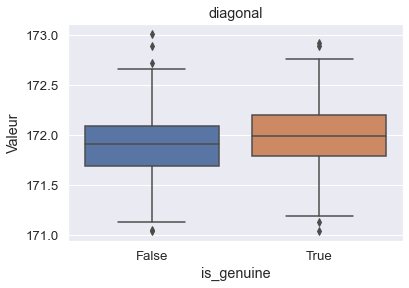

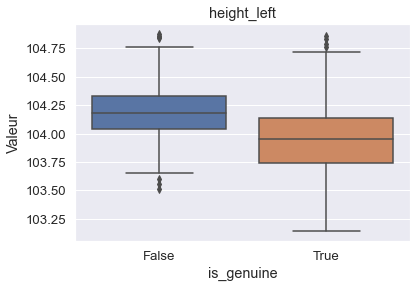

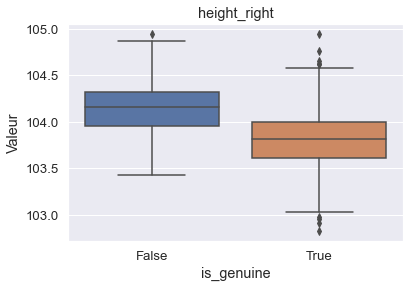

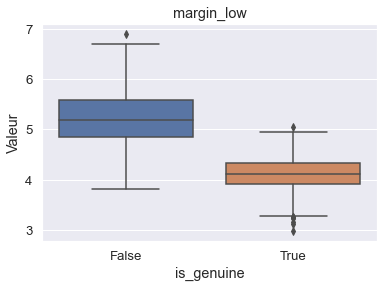

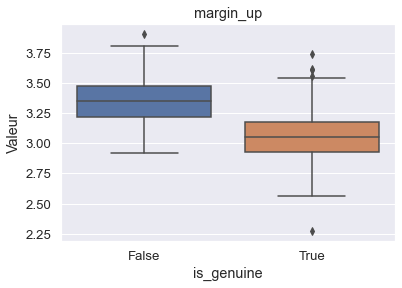

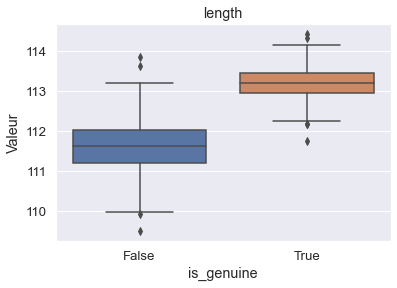

In [55]:
num_vars = billets_numeric.columns

# Générer un box plot pour chaque variable numérique
for var in num_vars:
    fig = plt.figure(figsize=(6, 4))
    sns.boxplot(x='is_genuine', y=var, data=billets)
    plt.title(var)
    plt.xlabel('is_genuine')
    plt.ylabel('Valeur')
    plt.show()
    fig.savefig(f'./graphiques/bivarie/boxplot_is_genuine_{var}.png', dpi=fig.dpi*10)
    plt.close(fig)

In [56]:
import scipy.stats as stats
# Initialiser les listes pour stocker les résultats
var_names = []
kw_stats = []
p_values = []

# Parcourir toutes les variables numériques
for var in num_vars:
    # Calculer les groupes de valeurs
    groups = [billets[billets['is_genuine_encode'] == 0][var], billets[billets['is_genuine_encode'] == 1][var]]
    # Appliquer le test de Kruskal-Wallis
    kw_stat, p = stats.kruskal(*groups)
    # Ajouter les résultats aux listes correspondantes
    var_names.append(var)
    kw_stats.append(kw_stat)
    p_values.append(p)

# Créer un DataFrame avec les résultats
results_df = pd.DataFrame({
    'Variable': var_names,
    'Kruskal-Wallis': kw_stats,
    'P-valeur': p_values
})

# Trier le DataFrame par ordre croissant de p-valeur
results_df.sort_values(by='P-valeur', inplace=True)

# Afficher le tableau des résultats
results_df

,Variable,Kruskal-Wallis,P-valeur
5,length,936.261971,1.285508e-205
3,margin_low,847.754857,2.237000e-186
4,margin_up,556.282611,5.411043e-123
2,height_right,363.527752,4.802156e-81
1,height_left,234.984537,4.879188e-53
0,diagonal,24.961602,5.848354e-07


#### Interpretation
Du point de vue de toutes les caracteristiques ci-dessus  , les vrais billets sont significativement differents des faux .
On peut noter par ailleurs que la variable 'diagonal' discrimine moins les faux billets des vrais par rapport aux autres variables.

[RETOUR AU SOMMAIRE](#00)